In [2]:
from wb.dataset import FileWBDataset

parquet_file = "/work/lecomtje/data/mpu/dataset/1000_1200/wind_bench.parquet"

dataset = FileWBDataset(parquet_file=parquet_file, indices=[0])
X, y = dataset[240]
print(X.shape)

(8, 1200)


In [5]:
import mlflow
from mlflow.models import ModelSignature
from mlflow.types.schema import TensorSpec, Schema
import numpy as np


input_schema = Schema([TensorSpec(type=np.dtype(np.float32), shape=X.shape)])
output_schema = Schema([TensorSpec(type=np.dtype(np.float32), shape=y.shape)])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)
print(signature)

model_uri = "/work/lecomtje/Repositories/wind_bench/mlruns/412467769945486489/df8d9efa626541878a90acd84791d3b4/artifacts/model"
pytorch_pyfunc = mlflow.pyfunc.load_model(model_uri=model_uri)

y_hat = pytorch_pyfunc.predict(X[np.newaxis, :, :])
print(y_hat)
print(y.shape, y_hat.shape)

inputs: 
  [Tensor('float32', (8, 1200))]
outputs: 
  [Tensor('float32', (1, 1200))]
params: 
  None

[[[0.6575732  0.7352431  0.75741875 ... 0.7551118  0.7564572  0.7583923 ]]]
(1, 1200) (1, 1, 1200)


In [7]:
import numpy
import json
from json import JSONEncoder
import requests
host='10.25.11.36'
port='5001'

url = f'http://{host}:{port}/invocations' 
headers = {'Content-Type': 'application/json',} 


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            print("encode ndarray")
            return obj.tolist()
        return JSONEncoder.default(self, obj)


# test_data is a Pandas dataframe with data for testing the ML model
data = { "instances": [X]}

json_object = json.dumps(data, cls=NumpyArrayEncoder)
print(json_object)

r = requests.post(url=url, headers=headers, data=json_object) 
print(f'Predictions: {r.text}')

result = json.loads(r.text)

y_hat_server = numpy.array(result['predictions'])
print(y.shape, y_hat_server.shape)

encode ndarray
{"instances": [[[0.5837719440460205, 0.5951983332633972, 0.6012555360794067, 0.6149963736534119, 0.626526951789856, 0.614923357963562, 0.6003589630126953, 0.5919142961502075, 0.5700936913490295, 0.5319259166717529, 0.48760706186294556, 0.45130544900894165, 0.4308193027973175, 0.41202211380004883, 0.40701785683631897, 0.4367097020149231, 0.4492724537849426, 0.4485843777656555, 0.439493328332901, 0.4196535646915436, 0.4064340591430664, 0.4074244499206543, 0.4228229522705078, 0.4399833381175995, 0.45878052711486816, 0.4772023856639862, 0.4943315088748932, 0.5229390859603882, 0.5518698692321777, 0.5703334808349609, 0.5841889381408691, 0.5723768472671509, 0.5288712382316589, 0.4828008711338043, 0.46094903349876404, 0.4778904616832733, 0.508937656879425, 0.5209999680519104, 0.5299763679504395, 0.5794870853424072, 0.6369837522506714, 0.650860071182251, 0.6259639859199524, 0.594406008720398, 0.5594075322151184, 0.5210416913032532, 0.5072174072265625, 0.527046799659729, 0.5522347

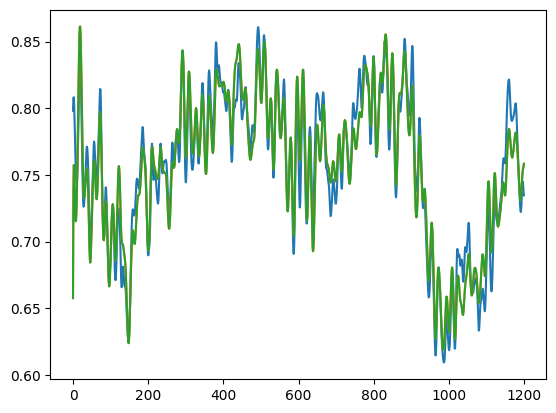

In [8]:
import matplotlib.pyplot as plt

plt.plot(y[0, :])
plt.plot(y_hat[0, 0, :])
plt.plot(y_hat_server[0, 0, :])